In [3]:
import pickle
import backtrader as bt
import yfinance as yf
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

# Data Collection & Setup

In [8]:
# Data retrieval
symbol = 'SPY'
df = yf.download(symbol, start='2015-01-01', end='2020-01-01')

# Adding technical indicators
df.ta.sma(length=10, append=True)
df.ta.wma(length=10, append=True)
df.dropna(inplace=True)

# Organizing columns
df = df[['Close', 'Open', 'Low', "SMA_10", 'WMA_10']]
df.head()

[*********************100%%**********************]  1 of 1 completed


,Close,Open,Low,SMA_10,WMA_10
Date,,,,,
2015-01-15,199.020004,201.630005,198.880005,202.403999,201.921818
2015-01-16,201.630005,198.770004,198.550003,202.024001,201.781092
2015-01-20,202.059998,202.399994,200.169998,202.058000,201.787637
2015-01-21,203.080002,201.500000,200.940002,202.384000,201.973455
2015-01-22,206.100006,203.990005,202.330002,202.763000,202.649093


# Data Scaling & Normalization

In [10]:
df = df.copy()
min_max_scalers = {} 
columns_to_scale = ['Close', 'Open', 'Low', 'SMA_10', 'WMA_10']
for col in columns_to_scale:
	scaler = MinMaxScaler()
	df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
	min_max_scalers[col] = scaler

{'Close': MinMaxScaler(),
 'Open': MinMaxScaler(),
 'Low': MinMaxScaler(),
 'SMA_10': MinMaxScaler(),
 'WMA_10': MinMaxScaler()}

In [38]:
# Save the dictionary using pickle
with open('scalers.pkl', 'wb') as file:
    pickle.dump(min_max_scalers, file)

In [14]:
def load_data(stock, seq_len):
    # Number of features in the datasct
    amount_of_features = len(stock.columns)
    # Converting DF to a numpy matrix
    data = stock.values
    sequence_length = seq_len + 1
    result = []
    # Creating data sequences of "sequence_length"
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    # Converting the list into a numpy matrix
    result = np.array(result)
    # Define training and test set
    row = round(0.9 * result.shape[0])
    # Splitting the dataset into training and test sets
    train = result[:int(row), :]
    X_train = train[:, :-1][:,:, 0:amount_of_features+1]
    y_train = train[:, -1][:,0]
    X_test = result[int(row):, :-1][:,:, 0:amount_of_features+1]
    y_test = result[int(row):, -1][:,0]
    # Reshaping the datasets to fit LSTM inputs
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))
    return [X_train, y_train, X_test, y_test]
    
X_train, y_train, X_test, y_test = load_data(df, 1)

# Building the LSTM Model

In [20]:
def build_optimized_model(features):
    model = Sequential()
    model.add(LSTM(512, input_shape=(1, features), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(512, input_shape=(1, features), return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(decay=0.1)
    model.compile(loss='mse', optimizer=optimizer)
    model.summary()
    return model

# Model Initialization & Training

In [21]:
model = build_optimized_model(features=5)
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=300,
    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1060864   
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,192,961
Trainable params: 3,192,961
Non-

In [37]:
# Save the model architecture and weights using .h5 
model.save('mylstm.h5')

# Model Evaluation

In [23]:
def model_score(y_test, y_predict):
    testMSE = mean_squared_error(y_test, y_predict)
    print('Test MSE: %.5f' % (testMSE))
    testMAE = mean_absolute_error(y_test, y_predict)
    print('Test MAE: %.5f' % (testMAE))
    return testMSE, testMAE

y_predict = model.predict(X_test)
model_score(y_test, y_predict)

4/4 [==============================] - 1s 4ms/step
Test MSE: 0.00045
Test MAE: 0.01556


(0.000445225204918508, 0.015556489261719207)

# Visualization

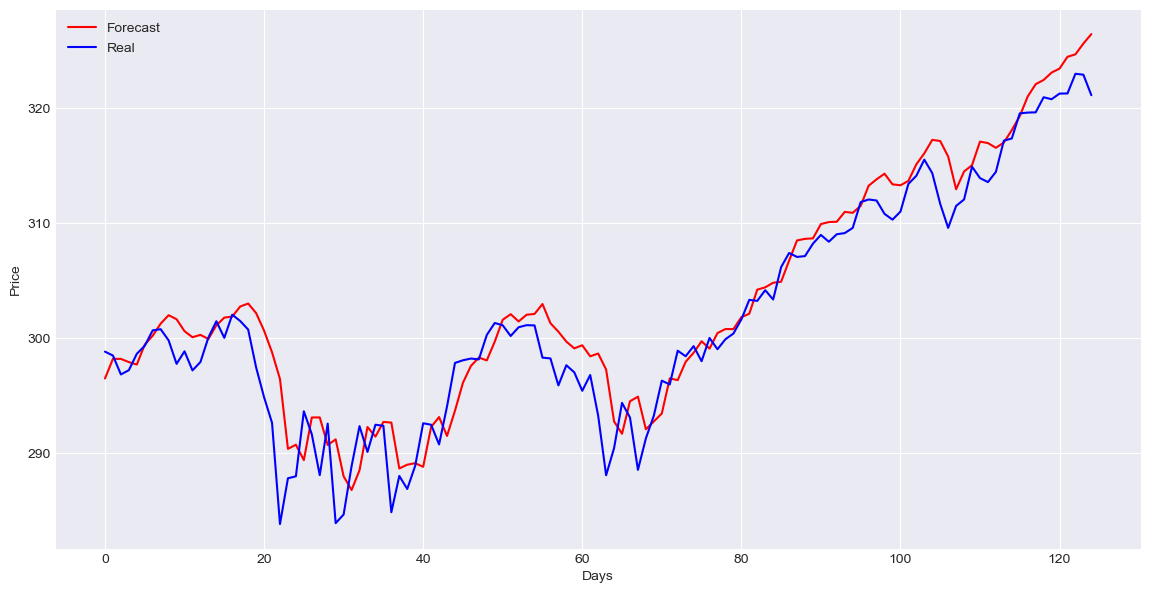

In [34]:
real_values_transformed = min_max_scalers['Close'].inverse_transform(y_test.reshape(-1, 1))
predicted_values_transformed = min_max_scalers['Close'].inverse_transform(y_predict.reshape(-1, 1))

def plot_results(predicted_values, real_values):
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14,7))
    plt.plot(predicted_values, color='red', label='Forecast') # remove the lag: np.roll(predicted_values, -1)
    plt.plot(real_values, color='blue', label='Real')
    plt.legend(loc='best')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
    
plot_results(predicted_values_transformed, real_values_transformed)

# Backtesting a trading strategy

A Long Position is indicated when stock prices are higher than their simple moving average, signaling an upward trend. 

Conversely, a Short Position is suggested when prices drop below the simple moving average, indicating a downward trend.

To determine the quantity of shares, we divide the available cash by the prevailing price..

» log: Captures and prints important events with timestamps.

» notify_order: Tracks the status of each order, logging whether it's executed, canceled, or rejected, and updates the self.order attribute accordingly.

## Regular strategy

In [5]:
class SMAStrategy(bt.Strategy):
    def __init__(self):
        # Initialization of the SMA indicator
        self.sma = bt.indicators.SMA(self.data.close, period=10)
        self.order = None
        
    def next(self):
        # If there is an open order, do nothing
        if self.order:
            return
            
        # Buy if the current price (Pt) is greater than the SMA (MAt(n))
        if not self.position and self.data.close[0] > self.sma[0]:
            cash = self.broker.get_cash() # Get the current cash level
            price = self.data.close[0] # Current price
            shares_to_buy = cash // price # Determine the number of shares to buy
            if shares_to_buy > 0:
                self.log('Create Buy: %.2f' % self.data.close[0])
                self.order = self.buy(size=shares_to_buy) # Place a buy order
        # Sell it the current price (Pt) is less than the SMA (MAt(n))
        elif self.position and self.data.close[0] < self.sma[0]:
            self.log('Create Sell: %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size) # Place a sell order

    def log(self, txt):
        dt = self.datas[0].datetime.date(0) # Get the current date
        print('%s, %s' % (dt.isoformat(), txt)) # Log the text with the date
        
    def notify_order(self, order):
        if order.status == order.Completed: # If the order is completed
            if order.isbuy():
                self.log(
                "BUY EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "SELL EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self) # Update the bar executed to the current length
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected") # Log if the order is not completed
        self.order = None # Reset the order object to None

## ML strategy

In [ ]:
class SMAStrategyPred(bt.Strategy):
    def __init__(self):
        # Empty list to store predicted closing prices
        self.predicted_closes = []
        # Indicators needed for prediction
        self.sma = bt.indicators.SMA(self.data.close, period=10) # Simple Moving Average
        self.wma = bt.indicators.WMA(self.data.close, period=10) # Weighted Moving Average
        # Load the LSTM model
        self.model = load_model('mylstm.h5')
        self.order = None
        # Load scaling objects for normalizing and denormalizing data
        with open("scalers.pkl", "rb") as f:
            self.scalers = pickle.load(f)

    def predict_close(self):
        # Scale data before making a prediction
        close_scaled = self.scalers['Close'].transform(np.array([self.data.close[0]]).reshape(-1, 1))
        open_scaled = self.scalers['Open'].transform(np.array([self.data.open[0]]).reshape(-1, 1))
        low_scaled = self.scalers['Low'].transform(np.array([self.data.low[0]]).reshape(-1, 1))
        sma_scaled = self.scalers['SMA_10'].transform(np.array([self.sma[0]]).reshape(-1, 1))
        wma_scaled = self.scalers['WMA_10'].transform(np.array([self.wma[0]]).reshape(-1, 1))
        # Consolidate current indicator values for prediction
        current_data = np.array([
            close_scaled[0][0],
            open_scaled[0][0],
            low_scaled[0][0],
            sma_scaled[0][0],
            wma_scaled[0][0]
        ]).reshape(1, 1, -1)
        # Predict the closing price using the model
        predicted_close_scaled = self.model.predict(current_data, verbose=0)[0][0]
        # Denormalize the predicted value back to original scale
        predicted_close = self.scalers['Close'].inverse_transform(np.array([[predicted_close_scaled]]))[0][0]
        return predicted_close

    def calculate_predicted_sma(self):
        # Calculate SMA based on predicted closing price, if we have at least 10 predictions
        if len(self.predicted_closes) < 10:
            return np.nan
        return np.mean(self.predicted_closes[-10:])
        
    def next(self):
        # If there is an open order, do nothing
        if self.order:
            return
        
        predicted_close = self.predict_close() # Predict next close
        self.predicted_closes.append(predicted_close) # Store prediction
        predicted_sma = self.calculate_predicted_sma() # Calculate predicted SMA
        if np.isnan(predicted_sma): # If SMA cannot be calculated, skip
            return
        
        # Buy if the current price (Pt) is greater than the SMA (MAt(n))
        if not self.position and predicted_close > predicted_sma:
            cash = self.broker.get_cash() # Get the current cash level
            price = self.data.close[0] # Current price
            shares_to_buy = cash // price # Determine the number of shares to buy
            if shares_to_buy > 0:
                self.log('Create Buy (Predicted price: %.2f), %.2f' % (predicted_close, self.data.close[0]))
                self.order = self.buy(size=shares_to_buy) # Place a buy order
        # Sell it the current price (Pt) is less than the SMA (MAt(n))
        elif self.position and predicted_close < predicted_sma:
            self.log('Create Sell (Predicted price: %.2f), %.2f' % (predicted_close, self.data.close[0]))
            self.order = self.sell(size=self.position.size) # Place a sell order

    def log(self, txt):
    	dt = self.datas[0].datetime.date(0) # Get the current date
    	print('%s, %s' % (dt.isoformat(), txt)) # Log the text with the date
        
    def notify_order(self, order):
        if order.status == order.Completed: # If the order is completed
            if order.isbuy():
                self.log(
                "BUY EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "SELL EXECUTED (Price: %.2f, Value: %.2f, Commission %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self) # Update the bar executed to the current length
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected") # Log if the order is not completed
        self.order = None # Reset the order object to None

## TEST

In [12]:
# Function to test trading strategies on a selected symbol and print the results
def test_strategies(strategies, ticker, start_date, end_date, starting_cash=100000):
    # Downloading the data for the selected stock symbol only once
    data_feed = bt.feeds.PandasData(dataname=yf.download(ticker, start=start_date, end=end_date))
    for strategy_class in strategies:
        cerebro = bt.Cerebro() # Initialize a new Cerebro engine instance
        cerebro.addstrategy(strategy_class) # Add the strategy class to Cerebro
        cerebro.broker.set_cash(starting_cash) # Set the starting cash
        cerebro.adddata(data_feed) # Add the data feed to Cerebro
        print(f'\Testing {strategy_class.__name__}')
        print('<START> Broker account balance: $%.2f' % cerebro.broker.getvalue())
        cerebro.run() # Run the strategy
        ending_cash = cerebro.broker.getvalue() # Get the ending cash balance
        total_return = calculate_total_return(ending_cash, starting_cash) # Calculate total return
        print('<FINISH> Broker account balance: $%.2f' % ending_cash)
        print(f"Total investment return: {total_return:.2f}%")
        # Plot the result graph
        # %matplotlib widget
        cerebro.plot(iplot=False) # filename='P&Lplot.png', show=False

In [8]:
# Function to calculate total return on investment
def calculate_total_return(ending_cash, starting_cash):
    return ((ending_cash - starting_cash) / starting_cash) * 100

## Main

In [13]:
# Define the list of strategies to be tested
strategies_to_test = [SMAStrategy, SMAStrategyPred]

# Call the test_strategies function with the specified parameters
test_strategies(strategies_to_test, 'SPY', '2020-01-01', '2023-10-01')

[*********************100%%**********************]  1 of 1 completed


\Testing SMAStrategy
<START> Broker account balance: $100000.00
2020-01-15, Create Buy: 328.19
2020-01-16, Order Canceled/Margin/Rejected
2020-01-16, Create Buy: 330.92
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Create Buy: 331.95
2020-01-21, BUY EXECUTED (Price: 330.90, Value: 99600.90, Commission 0.00)
2020-01-24, Create Sell: 328.77
2020-01-27, SELL EXECUTED (Price: 323.03, Value: 99600.90, Commission 0.00)
2020-02-04, Create Buy: 329.06
2020-02-05, Order Canceled/Margin/Rejected
2020-02-05, Create Buy: 332.86
2020-02-06, Order Canceled/Margin/Rejected
2020-02-06, Create Buy: 333.98
2020-02-07, BUY EXECUTED (Price: 332.82, Value: 97183.44, Commission 0.00)
2020-02-21, Create Sell: 333.48
2020-02-24, SELL EXECUTED (Price: 323.14, Value: 97183.44, Commission 0.00)
2020-03-25, Create Buy: 246.79
2020-03-26, Order Canceled/Margin/Rejected
2020-03-26, Create Buy: 261.20
2020-03-27, BUY EXECUTED (Price: 253.27, Value: 91683.74, Commission 0.00)
2020-04-01, Create Sell: 246.15


SMAStrategyPred Total investment return: 40.77% \
SMAStrategy Total investment return: -5.27% \
risk?